# Dependências

In [1]:
#!pip install xmltodict

In [2]:
import tensorflow as tf
#from pathlib import Path
import cv2
# import xmltodict

import keras

import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

# import sklearn

from PIL import Image, ImageDraw, ImageFont
import sklearn
from sklearn.model_selection import train_test_split

# Utils

In [3]:
def show_image_boxes(image_path, label, bbox):

  image = cv2.imread(image_path)
  (h, w) = image.shape[:2]

  class_name = classes[decode_classes(label)]
  bbox = (bbox[0] * w, bbox[1] * h, bbox[2] * w, bbox[3] * h)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = Image.fromarray(image.astype("uint8"))

  draw = ImageDraw.Draw(image)

  draw.rectangle(bbox, outline=(0, 255, 0))

  plt.imshow(image)
  plt.title(class_name)
  plt.show()


def encode_classes(class_id):

  if ( class_id == 0):
    encoded = np.array([1,0])
  else:
    encoded = np.array([0,1])

  return encoded

def decode_classes(encoded):
  if ( encoded[0]>encoded[1]):
    return 0
  else:
    return 1

def plot_train_valid_curves(training, validation, title, subplot):

    if subplot % 10 == 1:
        plt.subplots(figsize = (15,15), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation.'])

#Dataset

In [4]:
# Verifica se já foram baixadas as imagens do drive, baixando-as e descompactando se necessário
! [ ! -d "/content/cats_vs_dogs_obj_small" ] && gdown -O /content/cats_vs_dogs_obj_small.zip "1r52G52rLVPGZvcbNN7bjZX304GEMXVNs" &&  unzip -q /content/cats_vs_dogs_obj_small.zip -d /content && rm /content/cats_vs_dogs_obj_small.zip

# base_path = Path("/content/cats_vs_dogs_obj_small")

Downloading...
From: https://drive.google.com/uc?id=1r52G52rLVPGZvcbNN7bjZX304GEMXVNs
To: /content/cats_vs_dogs_obj_small.zip
100% 345M/345M [00:02<00:00, 154MB/s]


In [5]:
base_dir = "/content/cats_vs_dogs_obj_large/"
classes = ["cat", "dog"]

In [6]:
filename_list=[]
class_list = []
x1_list=[]
y1_list=[]
x2_list = []
y2_list = []

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
      if (filename.split('.')[1]=="jpg"):
        filename_list.append(filename)
        label_file = open(base_dir+filename.split('.')[0]+'.txt', 'r')
        label = label_file.read()
        label = [int(k) for k in label.split(' ')]
        label = np.array(label)
        class_num = label[0]-1
        class_list.append(class_num)
        x1_list.append(label[1])
        y1_list.append(label[2])
        x2_list.append(label[3])
        y2_list.append(label[4])

# df=pd.DataFrame()
# df['filename']=filename_list
# df['class_id']=class_id
# df['xmin']=xmin_list
# df['ymin']=ymin_list
# df['xmax']=xmax_list
# df['ymax']=ymax_list

# df.reset_index(drop=True, inplace=True)
# df.to_csv('images_with_boxes.csv')

In [7]:
HEIGHT=224
WIDTH=224

data = []
labels = []
coords = []
image_paths = []

for i in range(len(filename_list)):

  imagePath = base_dir+filename_list[i]

  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]

  image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(HEIGHT, WIDTH))
  image = tf.keras.preprocessing.image.img_to_array(image)

  label = encode_classes(class_list[i])

  xmin = float(x1_list[i]) / w
  ymin = float(y1_list[i]) / h
  xmax = float(x2_list[i]) / w
  ymax = float(y2_list[i]) / h

  data.append(image)
  labels.append(label)
  coords.append((xmin, ymin, xmax, ymax))

  image_paths.append(imagePath)

data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# lb = sklearn.preprocessing.LabelBinarizer()
# labels = lb.fit_transform(labels)
# if len(lb.classes_) == 2:
#   labels = to_categorical(labels)

coords = np.array(coords, dtype="float32")
image_paths = np.array(image_paths)

/content/cats_vs_dogs_obj_large/Bengal_150.jpg
[1 0]
[0.005      0.40782124 0.55       0.99441344]


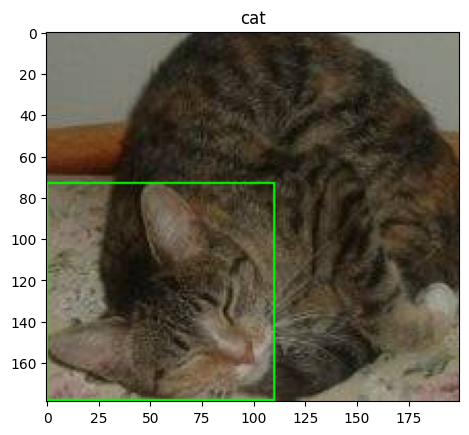

In [8]:
i = 100
print(image_paths[i])
print(labels[i])
print(coords[i])
show_image_boxes(image_paths[i], labels[i], coords[i])

#Arquitetura do Modelo

In [9]:
# Modelo YOLO simples

base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(WIDTH, HEIGHT, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
])


last_layer = base_model.layers[-1]
flatten = tf.keras.layers.Flatten()(last_layer.output)

coordHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
coordHead = tf.keras.layers.Dropout(0.1)(coordHead)
coordHead = tf.keras.layers.Dense(32, activation="relu")(coordHead)
coordHead = tf.keras.layers.Dropout(0.2)(coordHead)
coordHead = tf.keras.layers.Dense(4, activation="sigmoid", name="coords_output")(coordHead)

classHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
classHead = tf.keras.layers.Dropout(0.5)(classHead)
classHead = tf.keras.layers.Dense(32, activation="relu")(classHead)
classHead = tf.keras.layers.Dropout(0.6)(classHead)
classHead = tf.keras.layers.Dense(2, activation="softmax", name="class_output")(classHead)

model = tf.keras.Model(
inputs=base_model.input,
outputs=(coordHead, classHead))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam, loss={'coords_output': 'mse', 'class_output': 'binary_crossentropy'},
              metrics={'coords_output': 'accuracy', 'class_output': 'accuracy'})

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['conv2d_input[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         18496     ['max_pooling2d[0][0]']   

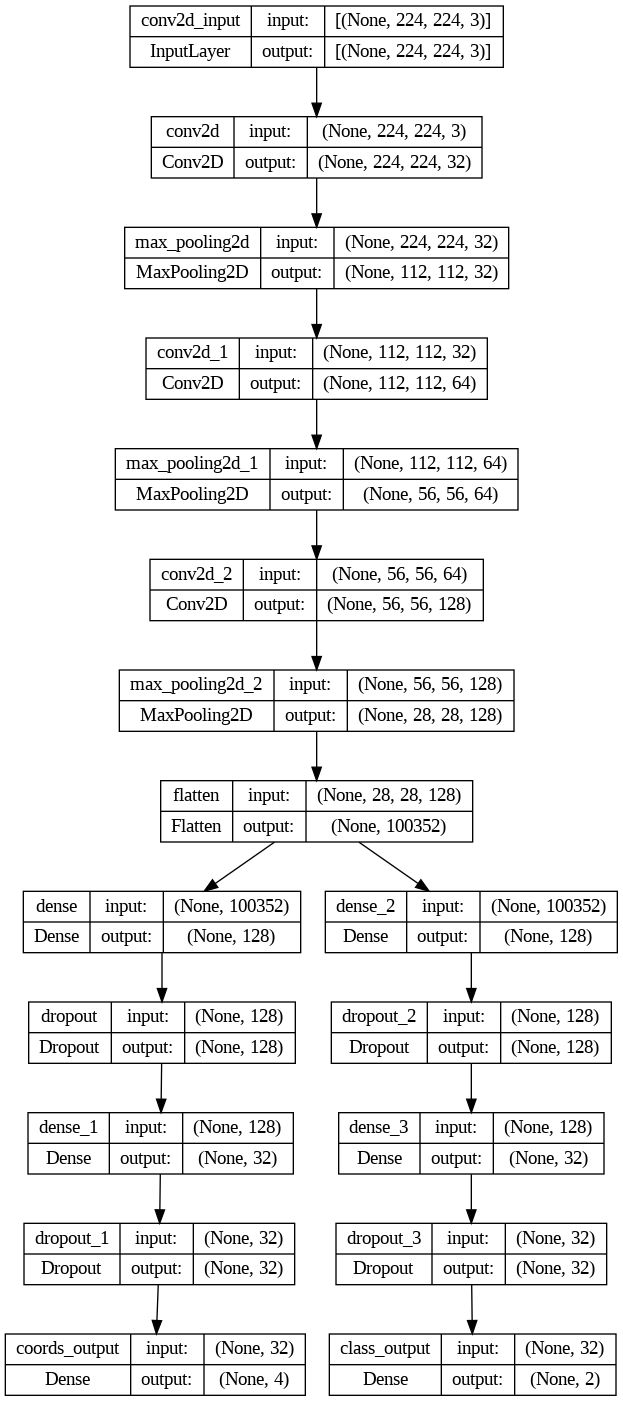

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Treinamento

In [11]:
split = train_test_split(data, labels, coords, image_paths, test_size=0.33, random_state=42)

(trainImages, valImages) = split[:2]
(trainLabels, valLabels) = split[2:4]
(trainCoords, valCoords) = split[4:6]
(trainPaths, valPaths) = split[6:]

trainTargets = {
	"class_output": trainLabels,
	"coords_output": trainCoords
}

valTargets = {
	"class_output": valLabels,
	"coords_output": valCoords
}


BATCH_SIZE=20
STEPS_PER_EPOCH=(len(trainImages)/BATCH_SIZE)
EPOCHS = 10

history = model.fit(
	trainImages, trainTargets,
	validation_data=(valImages, valTargets),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS,
  steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/10
113/113 [==============================] - 25s 74ms/step - loss: 0.7269 - coords_output_loss: 0.0393 - class_output_loss: 0.6876 - coords_output_accuracy: 0.6215 - class_output_accuracy: 0.6595 - val_loss: 0.6581 - val_coords_output_loss: 0.0278 - val_class_output_loss: 0.6303 - val_coords_output_accuracy: 0.6995 - val_class_output_accuracy: 0.6941
Epoch 2/10
113/113 [==============================] - 6s 50ms/step - loss: 0.6658 - coords_output_loss: 0.0308 - class_output_loss: 0.6349 - coords_output_accuracy: 0.6952 - class_output_accuracy: 0.6886 - val_loss: 0.6129 - val_coords_output_loss: 0.0218 - val_class_output_loss: 0.5910 - val_coords_output_accuracy: 0.6995 - val_class_output_accuracy: 0.6941
Epoch 3/10
113/113 [==============================] - 6s 52ms/step - loss: 0.6439 - coords_output_loss: 0.0248 - class_output_loss: 0.6191 - coords_output_accuracy: 0.7199 - class_output_accuracy: 0.6930 - val_loss: 0.5966 - val_coords_output_loss: 0.0207 - val_class_output_lo

In [12]:
history.history.keys()

dict_keys(['loss', 'coords_output_loss', 'class_output_loss', 'coords_output_accuracy', 'class_output_accuracy', 'val_loss', 'val_coords_output_loss', 'val_class_output_loss', 'val_coords_output_accuracy', 'val_class_output_accuracy'])

<ipython-input-3-5dd8400ee7c4>:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


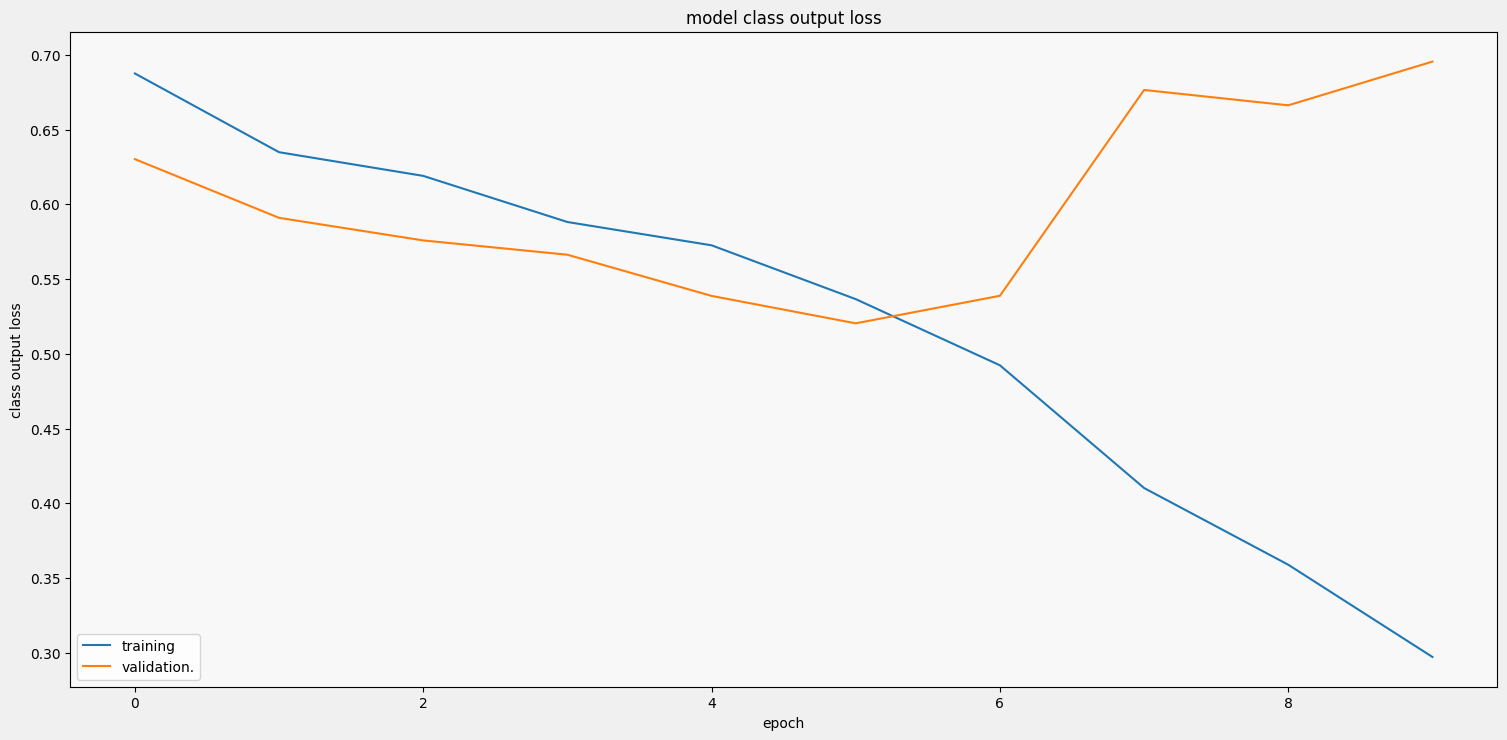

In [13]:
plot_train_valid_curves(history.history['class_output_loss'], history.history['val_class_output_loss'],  'class output loss', 211)


<ipython-input-3-5dd8400ee7c4>:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


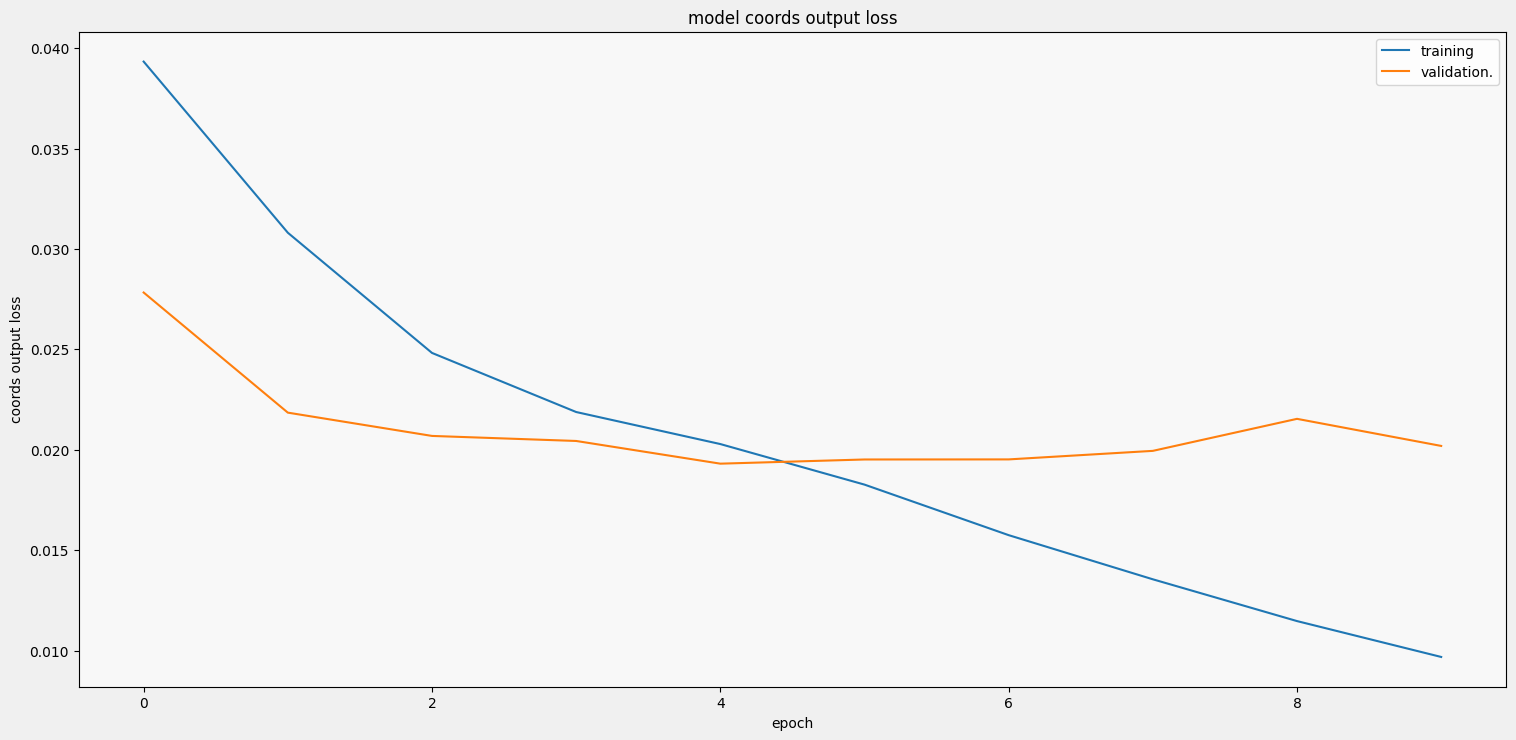

In [14]:
plot_train_valid_curves(history.history['coords_output_loss'],  history.history['val_coords_output_loss'], 'coords output loss', 211)

# Teste

1/1 [==============================] - 0s 133ms/step
/content/cats_vs_dogs_obj_large/scottish_terrier_144.jpg
[1.7513157e-08 1.0000000e+00]
[0.14961396 0.09903315 0.51022404 0.59013855]


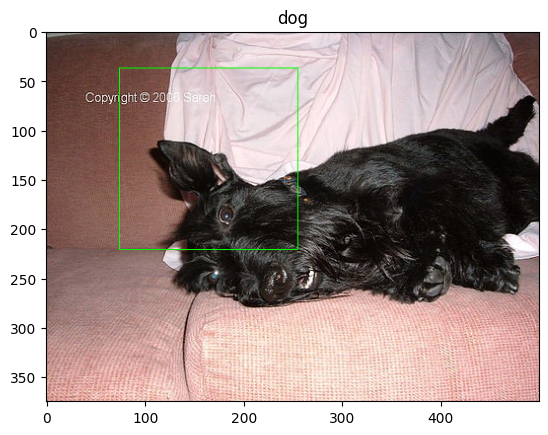

In [17]:
i = 0

(coordPreds, labelPreds) = model.predict(np.array([valImages[i]]))

print(valPaths[i])
print(labelPreds[0])
print(coordPreds[0])

show_image_boxes(valPaths[i], labelPreds[0], coordPreds[0])